In [1]:
IRT_DIMS = 0
DATASET = 'test_matrix'    
ITEM_FEATURES = 'True'
ITEM_FEATURES = False if ITEM_FEATURES == 'False' else True

In [2]:
import sys, os, shutil
import pickle
import time
import numpy as np
from utils import (load_data_heterogeneous, create_data_object_heterogeneous)
import seaborn as sns

#from IRT import MIRT_2PL
#from Heterogeneous_embedder_RT import EmbedderHeterogeneous, train_embedder_heterogeneous, test_embedder_heterogeneous
from manage_experiments import perform_cross_validation

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [3]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Initialise
parameters = {
    'df_name': None,
    'epochs': 10000,
    'learning_rate': 0.005,
    'weight_decay': 0,
    'early_stopping': 200,
    'n_splits': 10,
    'device': 'cuda:0',
    'batch_size': 2**16,
    'neighbours': [50, 50] #[-1, -1]
    }

if IRT_DIMS > 0:
    parameters['model_type'] = 'IRT'
    parameters['hidden_dims'] = IRT_DIMS
    parameters['lambda1'] = 0
    parameters['lambda2'] = 0
    OUTNAME = 'IRT'
else:
    parameters['model_type'] = 'GNN'
    parameters['hidden_dims'] = [8, 8]
    parameters['decoder_dim'] = 8
    parameters['batch_norm'] = False
    parameters['dropout'] = 0
    parameters['irt_output'] = False
    
    OUTNAME = 'SAGE' 

if ITEM_FEATURES:
    OUTNAME = OUTNAME + '_scales'
    
print(parameters)
print(DATASET)

{'df_name': None, 'epochs': 10000, 'learning_rate': 0.005, 'weight_decay': 0, 'early_stopping': 200, 'n_splits': 10, 'device': 'cuda:0', 'batch_size': 65536, 'neighbours': [50, 50], 'model_type': 'GNN', 'hidden_dims': [8, 8], 'decoder_dim': 8, 'batch_norm': False, 'dropout': 0, 'irt_output': False}
test_matrix


In [5]:
DATA_FILE = 'data/mindsteps_set_' + DATASET
df = load_data_heterogeneous(DATA_FILE)
data, df_student, df_item, df_edge = create_data_object_heterogeneous(df, return_aux_data=True, item_features=ITEM_FEATURES)

In [6]:
print(data)

HeteroData(
  student={
    node_id=[3779],
    x=[3779, 2],
  },
  item={
    node_id=[5925],
    x=[5925, 11],
  },
  (student, responds, item)={
    edge_index=[2, 327841],
    edge_attr=[327841, 2],
    y=[327841],
  },
  (item, rev_responds, student)={
    edge_index=[2, 327841],
    y=[327841],
  }
)


In [7]:
torch.exp(torch.tensor(-100000))

tensor(0.)

In [8]:
df.columns

Index(['studentId', 'code', 'motherTongue', 'Gender', 'scale', 'matrix',
       'IRT_difficulty', 'topic', 'responseformat', 'textlength', 'score',
       'age', 'grade', 'viewingTime', 'timestamp', 'useCase', 'assessmentId',
       'ability', 'frequency', 'previous_sessions', 'years_from_start',
       'matdiff', 'matcode', 'domain'],
      dtype='object')

In [9]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,timestamp,useCase,assessmentId,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,0.0,0.0,dles,D.2.B.1.f,0.268748,Zeitungsartikel,NaN,NaN,...,7.643058e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
1,0,1,0.0,0.0,dles,D.2.B.1.h,1.217388,Textsorten erkennen,single choice,NaN,...,7.643061e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
2,0,2,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.845624e-312,ms-kber,E109B3CDD31EDCFE7F48665587372C60A3FAEBB8571544...,2.421279,4.137915,6,1.45,,,d
3,0,3,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.851631e-312,ms-kber,319A0FE3AFDC0A30C4C1B26577B5B19FE66E918A181354...,2.174872,7.432378,11,1.48,,,d
4,0,4,0.0,0.0,dles,D.2.C.1.h,1.172410,Geschichten lang,single choice,NaN,...,7.643059e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d


edge_dim = data['student', 'responds', 'item'].edge_attr.shape[1]
if IRT_DIMS > 0:
    model = MIRT_2PL(IRT_DIMS, edge_dim, data)
else:
    model = EmbedderHeterogeneous( 
        n_students =  data['student'].x.size(0),
        n_items = data['item'].x.size(0),
        student_inchannel = data['student'].x.size(1),
        item_inchannel = data['item'].x.size(1),
        hidden_channels=parameters['hidden_dims'],
        edge_channel=edge_dim,
        metadata=data.metadata()
        ).to(device)
    
model = model.to(device)

In [10]:
output_dict, model = perform_cross_validation(data, parameters, save_embeddings=True, save_subgraph=True, final_fit=True)

0it [00:00, ?it/s]

Parameters
{'n_students': 3779, 'n_items': 5925, 'student_inchannel': 2, 'item_inchannel': 11, 'hidden_channels': [8, 8], 'decoder_channel': 8, 'edge_channel': 2, 'dropout': 0, 'batch_norm': False, 'irt_output': False, 'use_offset': True}



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]



Epoch: 001, Loss: 0.7732, Val: 0.4994, Test: 0.4988



  0%|          | 1/10000 [00:01<3:29:56,  1.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

  0%|          | 2/10000 [00:02<3:10:06,  1.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

  0%|          | 3/10000 [00:03<2:48:43,  1.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

  0%|          | 4/10000 [00:04<2:39:13,  1.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

  0%|          | 5/10000 [00:04<2:21:36,  1.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

  0%|          | 6/10000 [00:05<2:18:28,  1.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

  0%|          | 7/10000 [00:06<2:37:26,  1.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|          | 8/10000 [


Epoch: 012, Loss: 0.6027, Val: 0.5009, Test: 0.5008



  0%|          | 12/10000 [00:13<3:39:39,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]



Epoch: 013, Loss: 0.6054, Val: 0.5020, Test: 0.5012



  0%|          | 13/10000 [00:15<3:50:32,  1.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]



Epoch: 014, Loss: 0.6062, Val: 0.5022, Test: 0.5029



  0%|          | 14/10000 [00:17<4:20:32,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]



Epoch: 015, Loss: 0.6063, Val: 0.5026, Test: 0.5035



  0%|          | 15/10000 [00:19<4:38:51,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]



Epoch: 016, Loss: 0.6043, Val: 0.5030, Test: 0.5047



  0%|          | 16/10000 [00:21<4:50:16,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]



Epoch: 017, Loss: 0.6024, Val: 0.5043, Test: 0.5060



  0%|          | 17/10000 [00:22<4:59:43,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]



Epoch: 018, Loss: 0.5993, Val: 0.5045, Test: 0.5051



  0%|          | 18/10000 [00:24<4:55:28,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|          | 19/10000 [00:26<4:43:05,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|          | 20/10000 [00:27<4:33:58,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

  0%|          | 21/10000 [00:29<4:25:47,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|          | 22/10000 [00:30<4:14:47,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]



Epoch: 023, Loss: 0.5852, Val: 0.5053, Test: 0.5088



  0%|          | 23/10000 [00:32<4:22:33,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



Epoch: 024, Loss: 0.5831, Val: 0.5061, Test: 0.5105



  0%|          | 24/10000 [00:33<3:54:34,  1.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]



Epoch: 025, Loss: 0.5820, Val: 0.5073, Test: 0.5129



  0%|          | 25/10000 [00:34<4:00:47,  1.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]



Epoch: 026, Loss: 0.5800, Val: 0.5084, Test: 0.5141



  0%|          | 26/10000 [00:36<4:21:11,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]



Epoch: 027, Loss: 0.5799, Val: 0.5093, Test: 0.5146



  0%|          | 27/10000 [00:38<4:39:38,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

  0%|          | 28/10000 [00:40<4:28:21,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]



Epoch: 029, Loss: 0.5779, Val: 0.5098, Test: 0.5151



  0%|          | 29/10000 [00:41<4:41:42,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]



Epoch: 030, Loss: 0.5768, Val: 0.5103, Test: 0.5155



  0%|          | 30/10000 [00:43<4:46:56,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]



Epoch: 031, Loss: 0.5763, Val: 0.5112, Test: 0.5167



  0%|          | 31/10000 [00:45<4:23:33,  1.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]



Epoch: 032, Loss: 0.5751, Val: 0.5119, Test: 0.5170



  0%|          | 32/10000 [00:45<3:51:55,  1.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]



Epoch: 033, Loss: 0.5735, Val: 0.5134, Test: 0.5167



  0%|          | 33/10000 [00:47<3:48:34,  1.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.06it/s]



Epoch: 034, Loss: 0.5725, Val: 0.5144, Test: 0.5181



  0%|          | 34/10000 [00:48<3:29:43,  1.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]



Epoch: 035, Loss: 0.5711, Val: 0.5153, Test: 0.5200



  0%|          | 35/10000 [00:49<3:14:13,  1.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]



Epoch: 036, Loss: 0.5697, Val: 0.5170, Test: 0.5220



  0%|          | 36/10000 [00:50<3:26:48,  1.25s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



Epoch: 037, Loss: 0.5683, Val: 0.5187, Test: 0.5226



  0%|          | 37/10000 [00:52<4:08:04,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

  0%|          | 38/10000 [00:54<4:03:35,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]



Epoch: 039, Loss: 0.5650, Val: 0.5202, Test: 0.5263



  0%|          | 39/10000 [00:56<4:32:14,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



Epoch: 040, Loss: 0.5637, Val: 0.5213, Test: 0.5276



  0%|          | 40/10000 [00:57<4:38:28,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]



Epoch: 041, Loss: 0.5611, Val: 0.5228, Test: 0.5286



  0%|          | 41/10000 [00:59<4:07:00,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]



Epoch: 042, Loss: 0.5604, Val: 0.5235, Test: 0.5301



  0%|          | 42/10000 [01:01<4:34:05,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]



Epoch: 043, Loss: 0.5577, Val: 0.5260, Test: 0.5318



  0%|          | 43/10000 [01:03<4:56:05,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|          | 44/10000 [01:04<4:43:27,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]



Epoch: 045, Loss: 0.5544, Val: 0.5278, Test: 0.5337



  0%|          | 45/10000 [01:06<5:00:36,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]



Epoch: 046, Loss: 0.5524, Val: 0.5290, Test: 0.5354



  0%|          | 46/10000 [01:08<5:12:59,  1.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]



Epoch: 047, Loss: 0.5508, Val: 0.5301, Test: 0.5372



  0%|          | 47/10000 [01:10<5:07:23,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]



Epoch: 048, Loss: 0.5489, Val: 0.5312, Test: 0.5386



  0%|          | 48/10000 [01:12<5:26:21,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]



Epoch: 049, Loss: 0.5472, Val: 0.5348, Test: 0.5418



  0%|          | 49/10000 [01:15<5:38:39,  2.04s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]



Epoch: 050, Loss: 0.5452, Val: 0.5381, Test: 0.5448



  0%|          | 50/10000 [01:17<5:50:09,  2.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]



Epoch: 051, Loss: 0.5430, Val: 0.5405, Test: 0.5458



  1%|          | 51/10000 [01:18<5:09:21,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]



Epoch: 052, Loss: 0.5408, Val: 0.5427, Test: 0.5496



  1%|          | 52/10000 [01:20<5:10:37,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]



Epoch: 053, Loss: 0.5384, Val: 0.5448, Test: 0.5535



  1%|          | 53/10000 [01:22<5:24:13,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



Epoch: 054, Loss: 0.5359, Val: 0.5470, Test: 0.5563



  1%|          | 54/10000 [01:24<5:30:14,  1.99s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]



Epoch: 055, Loss: 0.5332, Val: 0.5501, Test: 0.5586



  1%|          | 55/10000 [01:26<5:34:10,  2.02s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]



Epoch: 056, Loss: 0.5313, Val: 0.5536, Test: 0.5612



  1%|          | 56/10000 [01:28<5:34:25,  2.02s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



Epoch: 057, Loss: 0.5290, Val: 0.5580, Test: 0.5643



  1%|          | 57/10000 [01:30<5:35:10,  2.02s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]



Epoch: 058, Loss: 0.5265, Val: 0.5613, Test: 0.5682



  1%|          | 58/10000 [01:31<4:50:03,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]



Epoch: 059, Loss: 0.5240, Val: 0.5643, Test: 0.5713



  1%|          | 59/10000 [01:33<4:18:33,  1.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]



Epoch: 060, Loss: 0.5215, Val: 0.5671, Test: 0.5748



  1%|          | 60/10000 [01:34<4:16:21,  1.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]



Epoch: 061, Loss: 0.5192, Val: 0.5708, Test: 0.5779



  1%|          | 61/10000 [01:35<3:50:44,  1.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]



Epoch: 062, Loss: 0.5163, Val: 0.5739, Test: 0.5811



  1%|          | 62/10000 [01:36<3:38:42,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]



Epoch: 063, Loss: 0.5142, Val: 0.5762, Test: 0.5839



  1%|          | 63/10000 [01:38<3:45:21,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]



Epoch: 064, Loss: 0.5117, Val: 0.5790, Test: 0.5880



  1%|          | 64/10000 [01:41<4:55:35,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]



Epoch: 065, Loss: 0.5092, Val: 0.5803, Test: 0.5917



  1%|          | 65/10000 [01:43<5:20:25,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]



Epoch: 066, Loss: 0.5071, Val: 0.5831, Test: 0.5949



  1%|          | 66/10000 [01:46<6:04:53,  2.20s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



Epoch: 067, Loss: 0.5038, Val: 0.5859, Test: 0.5964



  1%|          | 67/10000 [01:48<6:13:27,  2.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



Epoch: 068, Loss: 0.5022, Val: 0.5876, Test: 0.5985



  1%|          | 68/10000 [01:50<6:08:56,  2.23s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]



Epoch: 069, Loss: 0.4996, Val: 0.5895, Test: 0.5993



  1%|          | 69/10000 [01:51<5:04:50,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]



Epoch: 070, Loss: 0.4973, Val: 0.5920, Test: 0.6020



  1%|          | 70/10000 [01:53<4:58:18,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]



Epoch: 071, Loss: 0.4947, Val: 0.5934, Test: 0.6048



  1%|          | 71/10000 [01:55<5:18:44,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]



Epoch: 072, Loss: 0.4928, Val: 0.5960, Test: 0.6060



  1%|          | 72/10000 [01:57<5:30:30,  2.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



Epoch: 073, Loss: 0.4897, Val: 0.5985, Test: 0.6075



  1%|          | 73/10000 [01:59<5:42:30,  2.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]



Epoch: 074, Loss: 0.4875, Val: 0.6007, Test: 0.6095



  1%|          | 74/10000 [02:02<5:46:50,  2.10s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]



Epoch: 075, Loss: 0.4854, Val: 0.6024, Test: 0.6118



  1%|          | 75/10000 [02:04<5:58:12,  2.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.54s/it]



Epoch: 076, Loss: 0.4834, Val: 0.6037, Test: 0.6143



  1%|          | 76/10000 [02:07<6:30:57,  2.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]



Epoch: 077, Loss: 0.4806, Val: 0.6058, Test: 0.6154



  1%|          | 77/10000 [02:09<6:20:24,  2.30s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]



Epoch: 078, Loss: 0.4787, Val: 0.6074, Test: 0.6166



  1%|          | 78/10000 [02:11<6:11:27,  2.25s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]



Epoch: 079, Loss: 0.4762, Val: 0.6082, Test: 0.6179



  1%|          | 79/10000 [02:13<5:54:24,  2.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]



Epoch: 080, Loss: 0.4745, Val: 0.6097, Test: 0.6183



  1%|          | 80/10000 [02:14<5:16:51,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]



Epoch: 081, Loss: 0.4726, Val: 0.6108, Test: 0.6191



  1%|          | 81/10000 [02:17<5:31:05,  2.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]



Epoch: 082, Loss: 0.4702, Val: 0.6131, Test: 0.6212



  1%|          | 82/10000 [02:19<5:47:10,  2.10s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]



Epoch: 083, Loss: 0.4684, Val: 0.6145, Test: 0.6225



  1%|          | 83/10000 [02:21<6:08:10,  2.23s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]



Epoch: 084, Loss: 0.4659, Val: 0.6163, Test: 0.6250



  1%|          | 84/10000 [02:24<6:18:48,  2.29s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



Epoch: 085, Loss: 0.4639, Val: 0.6178, Test: 0.6270



  1%|          | 85/10000 [02:26<6:16:08,  2.28s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



Epoch: 086, Loss: 0.4618, Val: 0.6186, Test: 0.6288



  1%|          | 86/10000 [02:28<6:13:33,  2.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]



Epoch: 087, Loss: 0.4595, Val: 0.6193, Test: 0.6296



  1%|          | 87/10000 [02:29<5:21:03,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]



Epoch: 088, Loss: 0.4580, Val: 0.6205, Test: 0.6309



  1%|          | 88/10000 [02:31<4:54:45,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]



Epoch: 089, Loss: 0.4560, Val: 0.6217, Test: 0.6316



  1%|          | 89/10000 [02:32<4:31:08,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]



Epoch: 090, Loss: 0.4547, Val: 0.6230, Test: 0.6324



  1%|          | 90/10000 [02:33<4:03:04,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]



Epoch: 091, Loss: 0.4528, Val: 0.6240, Test: 0.6344



  1%|          | 91/10000 [02:34<3:44:45,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]



Epoch: 092, Loss: 0.4506, Val: 0.6247, Test: 0.6362



  1%|          | 92/10000 [02:36<4:19:13,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]



Epoch: 093, Loss: 0.4492, Val: 0.6262, Test: 0.6370



  1%|          | 93/10000 [02:39<5:04:44,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]



Epoch: 094, Loss: 0.4473, Val: 0.6283, Test: 0.6375



  1%|          | 94/10000 [02:41<5:29:55,  2.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]



Epoch: 095, Loss: 0.4462, Val: 0.6301, Test: 0.6383



  1%|          | 95/10000 [02:44<5:56:43,  2.16s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



Epoch: 096, Loss: 0.4441, Val: 0.6303, Test: 0.6391



  1%|          | 96/10000 [02:46<6:04:20,  2.21s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]



Epoch: 097, Loss: 0.4433, Val: 0.6315, Test: 0.6400



  1%|          | 97/10000 [02:47<5:05:54,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]



Epoch: 098, Loss: 0.4408, Val: 0.6318, Test: 0.6417



  1%|          | 98/10000 [02:49<5:14:16,  1.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]



Epoch: 099, Loss: 0.4403, Val: 0.6325, Test: 0.6420



  1%|          | 99/10000 [02:51<5:16:45,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]



Epoch: 100, Loss: 0.4385, Val: 0.6326, Test: 0.6423



  1%|          | 100/10000 [02:53<5:19:15,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]



Epoch: 101, Loss: 0.4362, Val: 0.6328, Test: 0.6434



  1%|          | 101/10000 [02:55<5:22:39,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



Epoch: 102, Loss: 0.4357, Val: 0.6331, Test: 0.6449



  1%|          | 102/10000 [02:57<5:36:02,  2.04s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]



Epoch: 103, Loss: 0.4336, Val: 0.6332, Test: 0.6456



  1%|          | 103/10000 [02:59<5:24:40,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



Epoch: 104, Loss: 0.4325, Val: 0.6348, Test: 0.6462



  1%|          | 104/10000 [03:02<5:50:11,  2.12s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]



Epoch: 105, Loss: 0.4315, Val: 0.6351, Test: 0.6461



  1%|          | 105/10000 [03:04<5:50:54,  2.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]



Epoch: 106, Loss: 0.4304, Val: 0.6363, Test: 0.6466



  1%|          | 106/10000 [03:06<5:46:43,  2.10s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]



Epoch: 107, Loss: 0.4290, Val: 0.6371, Test: 0.6473



  1%|          | 107/10000 [03:07<5:21:09,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]



Epoch: 108, Loss: 0.4274, Val: 0.6376, Test: 0.6469



  1%|          | 108/10000 [03:09<4:57:12,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

  1%|          | 109/10000 [03:10<4:41:07,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

  1%|          | 110/10000 [03:12<4:29:08,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

  1%|          | 111/10000 [03:13<4:20:27,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]



Epoch: 112, Loss: 0.4233, Val: 0.6389, Test: 0.6483



  1%|          | 112/10000 [03:15<4:40:02,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]



Epoch: 113, Loss: 0.4216, Val: 0.6398, Test: 0.6485



  1%|          | 113/10000 [03:17<4:59:04,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



Epoch: 114, Loss: 0.4211, Val: 0.6406, Test: 0.6495



  1%|          | 114/10000 [03:19<5:03:51,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]



Epoch: 115, Loss: 0.4203, Val: 0.6411, Test: 0.6499



  1%|          | 115/10000 [03:20<4:23:09,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

  1%|          | 116/10000 [03:21<3:44:48,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

  1%|          | 117/10000 [03:22<3:33:52,  1.30s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

  1%|          | 118/10000 [03:23<3:04:43,  1.12s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

  1%|          | 119/10000 [03:24<2:45:06,  1.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

  1%|          | 120/10000 [03:24<2:30:55,  1.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

  1%|          | 121/10000 [03:26<2:45:19,  1.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  1%|       


Epoch: 128, Loss: 0.4088, Val: 0.6412, Test: 0.6506



  1%|▏         | 128/10000 [03:36<3:58:56,  1.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]



Epoch: 129, Loss: 0.4082, Val: 0.6416, Test: 0.6513



  1%|▏         | 129/10000 [03:38<4:00:05,  1.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]



Epoch: 130, Loss: 0.4076, Val: 0.6420, Test: 0.6510



  1%|▏         | 130/10000 [03:40<4:19:32,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]



Epoch: 131, Loss: 0.4072, Val: 0.6422, Test: 0.6507



  1%|▏         | 131/10000 [03:42<4:32:46,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]



Epoch: 132, Loss: 0.4063, Val: 0.6426, Test: 0.6508



  1%|▏         | 132/10000 [03:43<4:45:24,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]



Epoch: 133, Loss: 0.4059, Val: 0.6431, Test: 0.6501



  1%|▏         | 133/10000 [03:45<4:54:49,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

  1%|▏         | 134/10000 [03:47<4:44:14,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

  1%|▏         | 135/10000 [03:48<4:22:32,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

  1%|▏         | 136/10000 [03:50<4:12:09,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]



Epoch: 137, Loss: 0.4037, Val: 0.6433, Test: 0.6503



  1%|▏         | 137/10000 [03:52<4:30:52,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]



Epoch: 138, Loss: 0.4035, Val: 0.6433, Test: 0.6501



  1%|▏         | 138/10000 [03:54<4:45:22,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

  1%|▏         | 139/10000 [03:55<4:29:42,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  1%|▏         | 140/10000 [03:56<3:46:07,  1.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

  1%|▏         | 141/10000 [03:56<3:13:54,  1.18s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

  1%|▏         | 142/10000 [03:57<2:59:08,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

  1%|▏         | 143/10000 [03:59<3:09:03,  1.15s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

  1%|▏         | 144/10000 [04:00<3:16:51,  1.20s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

  1%|▏      


Epoch: 156, Loss: 0.3965, Val: 0.6436, Test: 0.6514



  2%|▏         | 156/10000 [04:13<2:27:42,  1.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]



Epoch: 157, Loss: 0.3963, Val: 0.6437, Test: 0.6517



  2%|▏         | 157/10000 [04:14<2:44:56,  1.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]



Epoch: 158, Loss: 0.3958, Val: 0.6441, Test: 0.6521



  2%|▏         | 158/10000 [04:16<3:32:42,  1.30s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

  2%|▏         | 159/10000 [04:17<3:36:12,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

  2%|▏         | 160/10000 [04:18<3:26:38,  1.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

  2%|▏         | 161/10000 [04:20<3:43:24,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]



Epoch: 162, Loss: 0.3947, Val: 0.6447, Test: 0.6533



  2%|▏         | 162/10000 [04:22<4:06:42,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]



Epoch: 163, Loss: 0.3948, Val: 0.6448, Test: 0.6530



  2%|▏         | 163/10000 [04:23<3:53:36,  1.42s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



Epoch: 164, Loss: 0.3943, Val: 0.6455, Test: 0.6530



  2%|▏         | 164/10000 [04:25<4:32:59,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

  2%|▏         | 165/10000 [04:27<4:30:11,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]



Epoch: 166, Loss: 0.3942, Val: 0.6460, Test: 0.6524



  2%|▏         | 166/10000 [04:29<4:55:10,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]



Epoch: 167, Loss: 0.3943, Val: 0.6468, Test: 0.6520



  2%|▏         | 167/10000 [04:31<5:09:12,  1.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



Epoch: 168, Loss: 0.3941, Val: 0.6472, Test: 0.6521



  2%|▏         | 168/10000 [04:33<5:23:27,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]



Epoch: 169, Loss: 0.3934, Val: 0.6472, Test: 0.6521



  2%|▏         | 169/10000 [04:35<5:12:33,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]



Epoch: 170, Loss: 0.3933, Val: 0.6475, Test: 0.6520



  2%|▏         | 170/10000 [04:37<5:17:37,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



Epoch: 171, Loss: 0.3937, Val: 0.6483, Test: 0.6519



  2%|▏         | 171/10000 [04:39<5:28:54,  2.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

  2%|▏         | 172/10000 [04:41<5:02:55,  1.85s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

  2%|▏         | 173/10000 [04:42<4:28:22,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

  2%|▏         | 174/10000 [04:43<3:45:13,  1.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]



Epoch: 175, Loss: 0.3926, Val: 0.6492, Test: 0.6524



  2%|▏         | 175/10000 [04:44<4:07:40,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

  2%|▏         | 176/10000 [04:46<4:01:49,  1.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

  2%|▏         | 177/10000 [04:47<3:55:12,  1.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

  2%|▏         | 178/10000 [04:49<3:54:14,  1.43s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]



Epoch: 179, Loss: 0.3919, Val: 0.6493, Test: 0.6522



  2%|▏         | 179/10000 [04:50<4:16:19,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

  2%|▏         | 180/10000 [04:52<4:08:39,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]



Epoch: 181, Loss: 0.3919, Val: 0.6498, Test: 0.6523



  2%|▏         | 181/10000 [04:54<4:18:50,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

  2%|▏         | 182/10000 [04:54<3:34:50,  1.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.26it/s]



Epoch: 183, Loss: 0.3914, Val: 0.6498, Test: 0.6527



  2%|▏         | 183/10000 [04:55<3:16:18,  1.20s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

  2%|▏         | 184/10000 [04:56<3:08:30,  1.15s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]



Epoch: 185, Loss: 0.3921, Val: 0.6502, Test: 0.6525



  2%|▏         | 185/10000 [04:57<3:07:32,  1.15s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

  2%|▏         | 186/10000 [04:58<2:45:12,  1.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

  2%|▏         | 187/10000 [04:59<2:31:09,  1.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]



Epoch: 188, Loss: 0.3912, Val: 0.6502, Test: 0.6534



  2%|▏         | 188/10000 [05:01<3:17:20,  1.21s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]



Epoch: 189, Loss: 0.3907, Val: 0.6504, Test: 0.6535



  2%|▏         | 189/10000 [05:03<3:54:41,  1.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



Epoch: 190, Loss: 0.3906, Val: 0.6505, Test: 0.6539



  2%|▏         | 190/10000 [05:05<4:26:11,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

  2%|▏         | 191/10000 [05:06<4:20:44,  1.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]



Epoch: 192, Loss: 0.3905, Val: 0.6506, Test: 0.6546



  2%|▏         | 192/10000 [05:08<4:11:27,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

  2%|▏         | 193/10000 [05:09<3:41:54,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]



Epoch: 194, Loss: 0.3904, Val: 0.6507, Test: 0.6539



  2%|▏         | 194/10000 [05:11<4:11:19,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]



Epoch: 195, Loss: 0.3907, Val: 0.6509, Test: 0.6539



  2%|▏         | 195/10000 [05:13<4:50:00,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]



Epoch: 196, Loss: 0.3899, Val: 0.6511, Test: 0.6536



  2%|▏         | 196/10000 [05:15<5:20:34,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

  2%|▏         | 197/10000 [05:17<5:01:16,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]



Epoch: 198, Loss: 0.3902, Val: 0.6512, Test: 0.6536



  2%|▏         | 198/10000 [05:19<5:14:33,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]



Epoch: 199, Loss: 0.3903, Val: 0.6517, Test: 0.6537



  2%|▏         | 199/10000 [05:21<5:34:04,  2.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

  2%|▏         | 200/10000 [05:23<5:14:12,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

  2%|▏         | 201/10000 [05:24<4:51:44,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



Epoch: 202, Loss: 0.3899, Val: 0.6518, Test: 0.6551



  2%|▏         | 202/10000 [05:27<5:09:44,  1.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]



Epoch: 203, Loss: 0.3896, Val: 0.6519, Test: 0.6553



  2%|▏         | 203/10000 [05:28<4:38:47,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

  2%|▏         | 204/10000 [05:29<4:14:49,  1.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

  2%|▏         | 205/10000 [05:30<4:07:26,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

  2%|▏         | 206/10000 [05:32<4:07:38,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]



Epoch: 207, Loss: 0.3895, Val: 0.6522, Test: 0.6564



  2%|▏         | 207/10000 [05:34<4:44:09,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

  2%|▏         | 208/10000 [05:36<4:34:35,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

  2%|▏         | 209/10000 [05:37<4:23:43,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]



Epoch: 210, Loss: 0.3895, Val: 0.6524, Test: 0.6565



  2%|▏         | 210/10000 [05:39<4:48:30,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

  2%|▏         | 211/10000 [05:41<4:29:11,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

  2%|▏         | 212/10000 [05:42<3:48:24,  1.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.06it/s]



Epoch: 213, Loss: 0.3889, Val: 0.6525, Test: 0.6578



  2%|▏         | 213/10000 [05:43<3:29:36,  1.29s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]



Epoch: 214, Loss: 0.3891, Val: 0.6529, Test: 0.6575



  2%|▏         | 214/10000 [05:44<3:35:42,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

  2%|▏         | 215/10000 [05:45<3:05:33,  1.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

  2%|▏         | 216/10000 [05:45<2:44:13,  1.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.26it/s]



Epoch: 217, Loss: 0.3892, Val: 0.6531, Test: 0.6581



  2%|▏         | 217/10000 [05:46<2:42:07,  1.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

  2%|▏         | 218/10000 [05:47<2:32:25,  1.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]



Epoch: 219, Loss: 0.3890, Val: 0.6534, Test: 0.6584



  2%|▏         | 219/10000 [05:49<3:05:18,  1.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.34s/it]



Epoch: 220, Loss: 0.3889, Val: 0.6535, Test: 0.6587



  2%|▏         | 220/10000 [05:51<4:16:20,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]



Epoch: 221, Loss: 0.3889, Val: 0.6540, Test: 0.6591



  2%|▏         | 221/10000 [05:54<4:54:36,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]



Epoch: 222, Loss: 0.3890, Val: 0.6543, Test: 0.6591



  2%|▏         | 222/10000 [05:56<5:26:59,  2.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]



Epoch: 223, Loss: 0.3890, Val: 0.6548, Test: 0.6591



  2%|▏         | 223/10000 [05:59<5:51:45,  2.16s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]



Epoch: 224, Loss: 0.3885, Val: 0.6548, Test: 0.6595



  2%|▏         | 224/10000 [06:01<5:45:40,  2.12s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]



Epoch: 225, Loss: 0.3887, Val: 0.6550, Test: 0.6593



  2%|▏         | 225/10000 [06:02<5:02:29,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]



Epoch: 226, Loss: 0.3884, Val: 0.6551, Test: 0.6601



  2%|▏         | 226/10000 [06:04<5:10:57,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  2%|▏         | 227/10000 [06:05<4:50:52,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

  2%|▏         | 228/10000 [06:07<4:46:38,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]



Epoch: 229, Loss: 0.3887, Val: 0.6551, Test: 0.6604



  2%|▏         | 229/10000 [06:09<4:57:38,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]



Epoch: 230, Loss: 0.3882, Val: 0.6560, Test: 0.6609



  2%|▏         | 230/10000 [06:11<5:09:09,  1.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]



Epoch: 231, Loss: 0.3879, Val: 0.6563, Test: 0.6605



  2%|▏         | 231/10000 [06:13<5:09:00,  1.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

  2%|▏         | 232/10000 [06:15<4:57:54,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

  2%|▏         | 233/10000 [06:17<4:59:00,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]



Epoch: 234, Loss: 0.3882, Val: 0.6568, Test: 0.6602



  2%|▏         | 234/10000 [06:19<5:18:03,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]



Epoch: 235, Loss: 0.3881, Val: 0.6569, Test: 0.6604



  2%|▏         | 235/10000 [06:21<5:34:43,  2.06s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]



Epoch: 236, Loss: 0.3881, Val: 0.6571, Test: 0.6604



  2%|▏         | 236/10000 [06:23<5:37:07,  2.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]



Epoch: 237, Loss: 0.3877, Val: 0.6575, Test: 0.6606



  2%|▏         | 237/10000 [06:25<5:12:51,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]



Epoch: 238, Loss: 0.3883, Val: 0.6576, Test: 0.6606



  2%|▏         | 238/10000 [06:27<5:06:21,  1.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]



Epoch: 239, Loss: 0.3877, Val: 0.6579, Test: 0.6611



  2%|▏         | 239/10000 [06:29<5:14:42,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]



Epoch: 240, Loss: 0.3878, Val: 0.6582, Test: 0.6616



  2%|▏         | 240/10000 [06:31<5:14:58,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



Epoch: 241, Loss: 0.3882, Val: 0.6588, Test: 0.6616



  2%|▏         | 241/10000 [06:33<5:28:12,  2.02s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.38s/it]



Epoch: 242, Loss: 0.3876, Val: 0.6595, Test: 0.6618



  2%|▏         | 242/10000 [06:36<6:04:17,  2.24s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.32s/it]



Epoch: 243, Loss: 0.3877, Val: 0.6603, Test: 0.6616



  2%|▏         | 243/10000 [06:38<6:17:14,  2.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

  2%|▏         | 244/10000 [06:40<5:36:08,  2.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  2%|▏         | 245/10000 [06:40<4:34:46,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

  2%|▏         | 246/10000 [06:41<3:50:17,  1.42s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]



Epoch: 247, Loss: 0.3877, Val: 0.6608, Test: 0.6627



  2%|▏         | 247/10000 [06:42<3:41:43,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]



Epoch: 248, Loss: 0.3882, Val: 0.6612, Test: 0.6627



  2%|▏         | 248/10000 [06:44<3:38:38,  1.35s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

  2%|▏         | 249/10000 [06:45<3:10:39,  1.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]



Epoch: 250, Loss: 0.3878, Val: 0.6616, Test: 0.6633



  2%|▎         | 250/10000 [06:46<3:09:41,  1.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]



Epoch: 251, Loss: 0.3879, Val: 0.6620, Test: 0.6635



  3%|▎         | 251/10000 [06:48<3:44:22,  1.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]



Epoch: 252, Loss: 0.3872, Val: 0.6622, Test: 0.6636



  3%|▎         | 252/10000 [06:50<4:25:58,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]



Epoch: 253, Loss: 0.3872, Val: 0.6623, Test: 0.6641



  3%|▎         | 253/10000 [06:52<5:02:11,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]



Epoch: 254, Loss: 0.3875, Val: 0.6624, Test: 0.6644



  3%|▎         | 254/10000 [06:55<5:27:01,  2.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



Epoch: 255, Loss: 0.3873, Val: 0.6628, Test: 0.6638



  3%|▎         | 255/10000 [06:57<5:56:19,  2.19s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.28s/it]



Epoch: 256, Loss: 0.3876, Val: 0.6631, Test: 0.6638



  3%|▎         | 256/10000 [07:00<6:05:52,  2.25s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



Epoch: 257, Loss: 0.3865, Val: 0.6634, Test: 0.6643



  3%|▎         | 257/10000 [07:01<5:12:59,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]



Epoch: 258, Loss: 0.3876, Val: 0.6640, Test: 0.6643



  3%|▎         | 258/10000 [07:02<4:53:27,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]



Epoch: 259, Loss: 0.3877, Val: 0.6642, Test: 0.6648



  3%|▎         | 259/10000 [07:04<5:01:35,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]



Epoch: 260, Loss: 0.3874, Val: 0.6647, Test: 0.6653



  3%|▎         | 260/10000 [07:06<5:10:55,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]



Epoch: 261, Loss: 0.3869, Val: 0.6649, Test: 0.6661



  3%|▎         | 261/10000 [07:08<5:13:43,  1.93s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]



Epoch: 262, Loss: 0.3872, Val: 0.6650, Test: 0.6662



  3%|▎         | 262/10000 [07:10<5:14:07,  1.94s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]



Epoch: 263, Loss: 0.3869, Val: 0.6653, Test: 0.6659



  3%|▎         | 263/10000 [07:12<5:19:27,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

  3%|▎         | 264/10000 [07:14<4:51:54,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]



Epoch: 265, Loss: 0.3873, Val: 0.6656, Test: 0.6659



  3%|▎         | 265/10000 [07:16<5:16:20,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

  3%|▎         | 266/10000 [07:17<4:49:36,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

  3%|▎         | 267/10000 [07:19<4:33:48,  1.69s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]



Epoch: 268, Loss: 0.3876, Val: 0.6656, Test: 0.6657



  3%|▎         | 268/10000 [07:21<4:55:32,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]



Epoch: 269, Loss: 0.3866, Val: 0.6656, Test: 0.6660



  3%|▎         | 269/10000 [07:23<4:48:36,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]



Epoch: 270, Loss: 0.3869, Val: 0.6659, Test: 0.6657



  3%|▎         | 270/10000 [07:24<4:36:42,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]



Epoch: 271, Loss: 0.3869, Val: 0.6661, Test: 0.6658



  3%|▎         | 271/10000 [07:26<4:53:37,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]



Epoch: 272, Loss: 0.3868, Val: 0.6666, Test: 0.6660



  3%|▎         | 272/10000 [07:28<5:06:34,  1.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]



Epoch: 273, Loss: 0.3868, Val: 0.6671, Test: 0.6663



  3%|▎         | 273/10000 [07:30<5:19:42,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]



Epoch: 274, Loss: 0.3864, Val: 0.6672, Test: 0.6667



  3%|▎         | 274/10000 [07:33<5:26:33,  2.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]



Epoch: 275, Loss: 0.3864, Val: 0.6678, Test: 0.6671



  3%|▎         | 275/10000 [07:35<5:42:23,  2.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

  3%|▎         | 276/10000 [07:36<4:42:42,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]



Epoch: 277, Loss: 0.3864, Val: 0.6679, Test: 0.6676



  3%|▎         | 277/10000 [07:37<4:08:04,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]



Epoch: 278, Loss: 0.3859, Val: 0.6685, Test: 0.6677



  3%|▎         | 278/10000 [07:38<4:01:02,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]



Epoch: 279, Loss: 0.3866, Val: 0.6688, Test: 0.6679



  3%|▎         | 279/10000 [07:39<3:40:22,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]



Epoch: 280, Loss: 0.3864, Val: 0.6689, Test: 0.6679



  3%|▎         | 280/10000 [07:40<3:22:57,  1.25s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

  3%|▎         | 281/10000 [07:41<3:12:15,  1.19s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

  3%|▎         | 282/10000 [07:43<3:32:36,  1.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

  3%|▎         | 283/10000 [07:44<3:46:48,  1.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

  3%|▎         | 284/10000 [07:46<4:01:51,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

  3%|▎         | 285/10000 [07:48<4:07:34,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

  3%|▎         | 286/10000 [07:50<4:16:56,  1.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]



Epoch: 287, Loss: 0.3861, Val: 0.6691, Test: 0.6699



  3%|▎         | 287/10000 [07:51<4:15:44,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]



Epoch: 288, Loss: 0.3856, Val: 0.6692, Test: 0.6702



  3%|▎         | 288/10000 [07:53<4:15:55,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]



Epoch: 289, Loss: 0.3858, Val: 0.6696, Test: 0.6699



  3%|▎         | 289/10000 [07:55<4:37:05,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]



Epoch: 290, Loss: 0.3851, Val: 0.6702, Test: 0.6700



  3%|▎         | 290/10000 [07:57<4:51:40,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



Epoch: 291, Loss: 0.3852, Val: 0.6705, Test: 0.6702



  3%|▎         | 291/10000 [07:59<5:08:41,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]



Epoch: 292, Loss: 0.3856, Val: 0.6705, Test: 0.6706



  3%|▎         | 292/10000 [08:01<5:21:43,  1.99s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]



Epoch: 293, Loss: 0.3857, Val: 0.6711, Test: 0.6710



  3%|▎         | 293/10000 [08:03<5:18:25,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

  3%|▎         | 294/10000 [08:05<5:02:04,  1.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

  3%|▎         | 295/10000 [08:06<4:47:38,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

  3%|▎         | 296/10000 [08:08<4:36:07,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]



Epoch: 297, Loss: 0.3853, Val: 0.6718, Test: 0.6714



  3%|▎         | 297/10000 [08:10<4:54:20,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  3%|▎         | 298/10000 [08:11<4:38:06,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

  3%|▎         | 299/10000 [08:12<3:51:01,  1.43s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

  3%|▎         | 300/10000 [08:13<3:37:48,  1.35s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

  3%|▎         | 301/10000 [08:15<3:42:22,  1.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

  3%|▎         | 302/10000 [08:16<3:46:08,  1.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]



Epoch: 303, Loss: 0.3845, Val: 0.6719, Test: 0.6716



  3%|▎         | 303/10000 [08:18<4:13:31,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]



Epoch: 304, Loss: 0.3849, Val: 0.6723, Test: 0.6719



  3%|▎         | 304/10000 [08:20<4:30:55,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]



Epoch: 305, Loss: 0.3851, Val: 0.6727, Test: 0.6718



  3%|▎         | 305/10000 [08:22<4:51:08,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]



Epoch: 306, Loss: 0.3849, Val: 0.6727, Test: 0.6717



  3%|▎         | 306/10000 [08:24<4:42:15,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  3%|▎         | 307/10000 [08:25<3:59:06,  1.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

  3%|▎         | 308/10000 [08:25<3:26:55,  1.28s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

  3%|▎         | 309/10000 [08:27<3:21:43,  1.25s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

  3%|▎         | 310/10000 [08:27<2:55:28,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]



Epoch: 311, Loss: 0.3844, Val: 0.6728, Test: 0.6723



  3%|▎         | 311/10000 [08:28<2:59:18,  1.11s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

  3%|▎         | 312/10000 [08:29<2:51:38,  1.06s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

  3%|▎         | 313/10000 [08:31<3:19:29,  1.24s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  3%|▎         | 314/10000 [08:33<3:32:58,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

  3%|▎         | 315/10000 [08:34<3:47:46,  1.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]



Epoch: 316, Loss: 0.3838, Val: 0.6735, Test: 0.6734



  3%|▎         | 316/10000 [08:36<4:31:52,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]



Epoch: 317, Loss: 0.3837, Val: 0.6735, Test: 0.6739



  3%|▎         | 317/10000 [08:39<5:06:30,  1.90s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]



Epoch: 318, Loss: 0.3841, Val: 0.6739, Test: 0.6731



  3%|▎         | 318/10000 [08:40<4:26:54,  1.65s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

  3%|▎         | 319/10000 [08:41<4:07:26,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

  3%|▎         | 320/10000 [08:43<3:59:39,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

  3%|▎         | 321/10000 [08:44<3:55:25,  1.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]



Epoch: 322, Loss: 0.3839, Val: 0.6742, Test: 0.6745



  3%|▎         | 322/10000 [08:46<4:16:03,  1.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

  3%|▎         | 323/10000 [08:47<4:08:02,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

  3%|▎         | 324/10000 [08:49<4:01:55,  1.50s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

  3%|▎         | 325/10000 [08:50<4:05:12,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]



Epoch: 326, Loss: 0.3829, Val: 0.6742, Test: 0.6751



  3%|▎         | 326/10000 [08:52<4:10:22,  1.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  3%|▎         | 327/10000 [08:53<4:06:10,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

  3%|▎         | 328/10000 [08:55<3:57:01,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]



Epoch: 329, Loss: 0.3836, Val: 0.6747, Test: 0.6754



  3%|▎         | 329/10000 [08:57<4:21:15,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]



Epoch: 330, Loss: 0.3826, Val: 0.6748, Test: 0.6755



  3%|▎         | 330/10000 [08:59<4:37:27,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]



Epoch: 331, Loss: 0.3827, Val: 0.6752, Test: 0.6752



  3%|▎         | 331/10000 [09:00<4:03:13,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]



Epoch: 332, Loss: 0.3826, Val: 0.6756, Test: 0.6760



  3%|▎         | 332/10000 [09:01<4:00:14,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

  3%|▎         | 333/10000 [09:02<3:53:04,  1.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

  3%|▎         | 334/10000 [09:04<3:45:23,  1.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

  3%|▎         | 335/10000 [09:05<3:40:31,  1.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

  3%|▎         | 336/10000 [09:06<3:39:53,  1.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

  3%|▎         | 337/10000 [09:08<3:41:54,  1.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

  3%|▎         | 338/10000 [09:09<3:43:17,  1.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

  3%|▎      


Epoch: 352, Loss: 0.3804, Val: 0.6763, Test: 0.6770



  4%|▎         | 352/10000 [09:25<3:55:41,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  4%|▎         | 353/10000 [09:26<3:59:31,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

  4%|▎         | 354/10000 [09:28<4:08:29,  1.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

  4%|▎         | 355/10000 [09:29<4:07:12,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

  4%|▎         | 356/10000 [09:31<4:10:06,  1.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

  4%|▎         | 357/10000 [09:33<4:10:53,  1.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]



Epoch: 358, Loss: 0.3799, Val: 0.6763, Test: 0.6768



  4%|▎         | 358/10000 [09:36<5:35:46,  2.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

  4%|▎         | 359/10000 [09:37<4:58:12,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

  4%|▎         | 360/10000 [09:39<4:47:05,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

  4%|▎         | 361/10000 [09:41<4:42:02,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

  4%|▎         | 362/10000 [09:42<4:35:29,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  4%|▎         | 363/10000 [09:44<4:27:25,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

  4%|▎         | 364/10000 [09:45<4:07:35,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

  4%|▎      


Epoch: 434, Loss: 0.3692, Val: 0.6764, Test: 0.6747



  4%|▍         | 434/10000 [11:23<4:06:23,  1.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]



Epoch: 435, Loss: 0.3699, Val: 0.6765, Test: 0.6745



  4%|▍         | 435/10000 [11:25<4:23:56,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]



Epoch: 436, Loss: 0.3695, Val: 0.6771, Test: 0.6746



  4%|▍         | 436/10000 [11:26<4:38:35,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

  4%|▍         | 437/10000 [11:28<4:24:42,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

  4%|▍         | 438/10000 [11:29<4:14:52,  1.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

  4%|▍         | 439/10000 [11:31<4:05:41,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

  4%|▍         | 440/10000 [11:32<4:07:15,  1.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

  4%|▍         | 441/10000 [11:33<3:36:08,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

  4%|▍         | 442/10000 [11:35<4:02:14,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

  4%|▍      


Epoch: 498, Loss: 0.3617, Val: 0.6772, Test: 0.6734



  5%|▍         | 498/10000 [12:47<2:27:52,  1.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

  5%|▍         | 499/10000 [12:47<2:17:18,  1.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]



Epoch: 500, Loss: 0.3612, Val: 0.6774, Test: 0.6724



  5%|▌         | 500/10000 [12:49<2:51:36,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]



Epoch: 501, Loss: 0.3611, Val: 0.6779, Test: 0.6722



  5%|▌         | 501/10000 [12:51<3:35:00,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

  5%|▌         | 502/10000 [12:52<3:38:15,  1.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

  5%|▌         | 503/10000 [12:54<3:43:40,  1.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

  5%|▌         | 504/10000 [12:55<3:46:19,  1.43s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

  5%|▌         | 505/10000 [12:56<3:19:11,  1.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

  5%|▌         | 506/10000 [12:57<3:00:36,  1.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

  5%|▌         | 507/10000 [12:58<3:14:21,  1.23s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

  5%|▌      


Epoch: 513, Loss: 0.3591, Val: 0.6780, Test: 0.6724



  5%|▌         | 513/10000 [13:07<3:53:38,  1.48s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]



Epoch: 514, Loss: 0.3595, Val: 0.6780, Test: 0.6726



  5%|▌         | 514/10000 [13:09<4:09:43,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

  5%|▌         | 515/10000 [13:10<4:05:11,  1.55s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]



Epoch: 516, Loss: 0.3589, Val: 0.6785, Test: 0.6727



  5%|▌         | 516/10000 [13:12<4:29:42,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

  5%|▌         | 517/10000 [13:14<4:15:53,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]



Epoch: 518, Loss: 0.3586, Val: 0.6785, Test: 0.6729



  5%|▌         | 518/10000 [13:15<4:15:14,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

  5%|▌         | 519/10000 [13:16<3:41:33,  1.40s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

  5%|▌         | 520/10000 [13:18<3:36:15,  1.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

  5%|▌         | 521/10000 [13:19<3:34:25,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

  5%|▌         | 522/10000 [13:20<3:35:04,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

  5%|▌         | 523/10000 [13:22<3:38:14,  1.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

  5%|▌         | 524/10000 [13:23<3:47:23,  1.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

  5%|▌      


Epoch: 554, Loss: 0.3548, Val: 0.6786, Test: 0.6711



  6%|▌         | 554/10000 [14:04<3:52:11,  1.47s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

  6%|▌         | 555/10000 [14:05<3:26:21,  1.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  6%|▌         | 556/10000 [14:07<3:36:55,  1.38s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

  6%|▌         | 557/10000 [14:09<3:49:55,  1.46s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]



Epoch: 558, Loss: 0.3541, Val: 0.6792, Test: 0.6701



  6%|▌         | 558/10000 [14:11<4:22:21,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.47s/it]



Epoch: 559, Loss: 0.3541, Val: 0.6796, Test: 0.6697



  6%|▌         | 559/10000 [14:13<5:07:26,  1.95s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

  6%|▌         | 560/10000 [14:15<4:59:59,  1.91s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

  6%|▌         | 561/10000 [14:17<4:49:41,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

  6%|▌         | 562/10000 [14:19<4:45:19,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

  6%|▌         | 563/10000 [14:20<4:07:01,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

  6%|▌         | 564/10000 [14:20<3:26:07,  1.31s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

  6%|▌         | 565/10000 [14:21<2:58:43,  1.14s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

  6%|▌      


Epoch: 619, Loss: 0.3483, Val: 0.6799, Test: 0.6694



  6%|▌         | 619/10000 [15:38<4:14:13,  1.63s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]



Epoch: 620, Loss: 0.3480, Val: 0.6803, Test: 0.6687



  6%|▌         | 620/10000 [15:39<4:21:14,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

  6%|▌         | 621/10000 [15:41<4:11:21,  1.61s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

  6%|▌         | 622/10000 [15:42<4:03:14,  1.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

  6%|▌         | 623/10000 [15:44<4:03:31,  1.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

  6%|▌         | 624/10000 [15:46<4:13:02,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

  6%|▋         | 625/10000 [15:47<4:15:31,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

  6%|▋         | 626/10000 [15:49<4:15:55,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

  6%|▋      

Train balanced accuracy:0.7726


In [11]:
output_dict.keys()
print('Train AUC :', output_dict['AUC_0_train'])
print('Train Balanced Accuracy:', output_dict['Balanced Accuracy_0_train'])
print('Val AUC:', output_dict['AUC_0_val'])
print('Val Balanced Accuracy:', output_dict['Balanced Accuracy_0_val'])
print('Test AUC:', output_dict['AUC_0_test'])
print('Test Balanced Accuracy:', output_dict['Balanced Accuracy_0_test'])

Train AUC : 0.8572099248938343
Train Balanced Accuracy: 0.772617169605111
Val AUC: 0.7429006010455781
Val Balanced Accuracy: 0.6803462401803664
Test AUC: 0.7374802780249894
Test Balanced Accuracy: 0.6686722347446821


In [12]:
print(output_dict['Balanced Accuracy Ber2_0_train'], output_dict['Balanced Accuracy Ber1_0_train'])

0.6926188391137976 0.6931368829920814


In [13]:
unique_scales = df_item['scale'].unique()
unique_domains = df_item['domain'].unique()
unique_matdiff = df_item['matdiff'].sort_values().unique()
#scale_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_scales)])
#domain_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_domains)])

In [14]:
train_losses = output_dict['losses_0']
train_edge_indices, val_edge_indices, test_edge_indices = output_dict['indices_0']

train_data = output_dict['train_subgraph_data'] 
val_data = output_dict['val_subgraph_data'] 
test_data = output_dict['test_subgraph_data']

aux_data = (df, df_student, df_item, df_edge, 
    #clustering_indices, 
    train_losses, #test_losses, test_aucs, 
    train_edge_indices, val_edge_indices, test_edge_indices, 
    data.cpu(), train_data.cpu(), val_data.cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

with open(f'./results/{OUTNAME}_{DATASET}_aux_data.pkl', 'wb') as handle:
    pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# SAVE EVERYTHING
torch.save(model, f'./results/{OUTNAME}_{DATASET}.pth.tar')

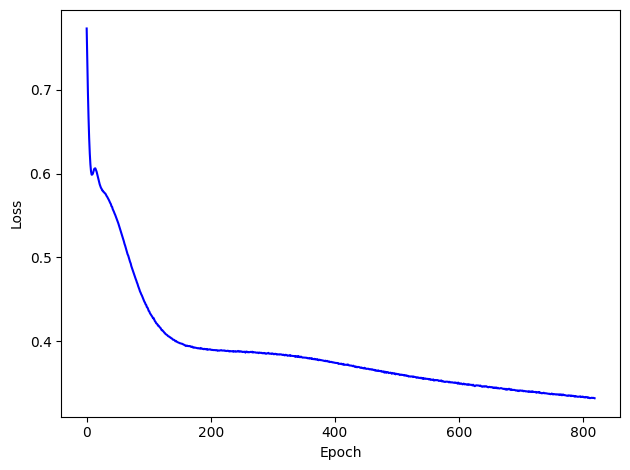

In [16]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()

In [17]:
# save IRT parameters to matrix
if ('IRT' in OUTNAME) and IRT_DIMS == 1:    
    #z_dict = model.get_embeddings(train_data.to(device))
    z_dict = output_dict['embedding_0']
    df_item['IRT1_difficulty'] = -z_dict['offset']
    df_item['IRT1_discrimination'] = z_dict['discrimination']
    df_item['IRT1_discrimination_transf'] = z_dict['item']
    ability = z_dict['ability']
    df_edge['IRT1_ability'] = ability.ravel()
    
    aux_data = (df, df_student, df_item, df_edge, 
    train_losses, 
    train_edge_indices, val_edge_indices, test_edge_indices,
    data.cpu(), train_data.cpu(), val_data.cpu().cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

    with open(f'./results/{OUTNAME}_{DATASET}_aux_data_IRT1.pkl', 'wb') as handle:
        pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    df_item_clean = df_item.dropna(subset=['IRT_difficulty', 'IRT1_difficulty'])    
    
    fig = plt.figure()
    sns.scatterplot(x='IRT_difficulty', y='IRT1_difficulty', data=df_item, hue='scale')
    plt.title('Difficulty')
    print('Difficulty:', pearsonr(df_item_clean['IRT1_difficulty'], df_item_clean['IRT_difficulty']))
    
    edge_feat = train_data['student', 'responds', 'item'].edge_attr.detach().cpu().numpy()
    df_edge_clean = df_edge.dropna(subset=['IRT1_ability', 'ability', 'age'])
    fig = plt.figure()
    sns.scatterplot(x='age', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Age-Ability')
    
    fig = plt.figure()
    sns.scatterplot(x='grade', y='IRT1_ability', data=df_edge_clean, hue='age')
    plt.title('Grade-Ability')
    print('Age-Ability:', pearsonr(df_edge_clean['age'], df_edge_clean['IRT1_ability']))

    fig = plt.figure()
    sns.scatterplot(x='ability', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Ability')
    print('Ability:', pearsonr(df_edge_clean['ability'], df_edge_clean['IRT1_ability']))
    